Import libs and define some helpful functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier, Pool
from category_encoders import TargetEncoder
from datetime import datetime
from dateutil.relativedelta import relativedelta
import scipy

In [2]:
def plot_dist_formated(col):
    plt.figure(figsize=(9,6))
    sns.distplot(data_1[col])
    plt.title("Distribution plot of '%s' variable" % col)
    plt.show()

In [3]:
def plot_boxplot_formated(col):
    plt.figure(figsize=(9,6))
    sns.boxplot(x=data_1[col], y=data_1.y)
    plt.title("Boxplot of '%s' variable" % col)
    plt.show()

In [4]:
def plot_countplot_formated(col, order=None, orient='v'):
    plt.figure(figsize=(15,6))
    if orient=='v':
        sns.countplot(data_1[col], order=order)
    else:
        sns.countplot(y=data_1[col], order=order)
    plt.title("Countplot of '%s' variable" % col)
    plt.show()

In [5]:
def plot_barplot_formated(col, order=None, orient='v'):
    plt.figure(figsize=(15,6))
    tmp_df = data_1[[col, 'y_num']].groupby([col], as_index=False).y_num.mean()
    if orient=='v':
        sns.barplot(x=tmp_df[col], y=tmp_df.y_num, order=order)
    else:
        sns.barplot(y=tmp_df[col], x=tmp_df.y_num, order=order, orient='h')
    plt.title("Barplot of '%s' variable" % col)
    plt.ylabel('Subscription part')
    plt.show()

In [6]:
def plot_time_var(col):
    plt.figure(figsize=(18,6))
    tmp_df = data_1[['dt',col]].drop_duplicates()
    plt.plot(tmp_df.dt,tmp_df[col])
    plt.xticks(rotation=90)
    plt.title("Plot of '%s' variable" % col)
    plt.ylabel('Value')
    plt.show()

In [7]:
month_order = []
month_dict = {}
st_date = datetime(2019, 1, 1)
for i in range(12):
    month_order.append(st_date.strftime('%b').lower())
    month_dict[st_date.strftime('%b').lower()] = i+1
    st_date += relativedelta(months=1)

In [8]:
month_order_cv = []
st_date = datetime(2008, 3, 1)
while st_date < datetime(2011, 1, 1):
    month_order_cv.append(st_date.strftime('%b_%Y').lower())
    st_date += relativedelta(months=1)

In [9]:
def create_time_diff(col):
    tmp_df = data_1[['dt_tmp',col]].drop_duplicates()
    #print(tmp_df)
    res = {}
    prev_month = None
    prev_val = None
    #print(len(tmp_df))
    for row in tmp_df.itertuples():
        #print(row.dt_tmp)
        #print(row.dt_tmp-relativedelta(months=1))
        if prev_month and prev_month==(row.dt_tmp-relativedelta(months=1)):
            res[row.dt_tmp.strftime('%b_%Y').lower()] = row[2]-prev_val
        else:
            res[row.dt_tmp.strftime('%b_%Y').lower()] = 0
        prev_month = row.dt_tmp
        prev_val = row[2]
    return res

Read data

In [10]:
data_1 = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

Let manually add year of call.

In [11]:
prev_month = None
years = []
year=2008
for row in data_1.itertuples():
    if prev_month=='dec' and row.month!='dec':
        year +=1
    years.append(year)
    prev_month=row.month
data_1['year']=years

In [12]:
data_1['dt'] = data_1.apply(lambda x: x.month+'_'+str(x.year), axis=1)
data_1['dt_tmp'] = data_1.apply(lambda x: datetime(x.year, month_dict[x.month], 1), axis=1) # temp column for feature generation

In [13]:
data_1.dt.value_counts(True)

may_2008    0.188477
jul_2008    0.162305
may_2009    0.140672
aug_2008    0.125643
jun_2008    0.106196
nov_2008    0.087793
apr_2009    0.059678
aug_2009    0.018695
jun_2009    0.017359
oct_2009    0.010853
nov_2009    0.008668
jul_2010    0.007551
sep_2010    0.007357
mar_2009    0.006847
sep_2009    0.006482
mar_2010    0.006410
aug_2010    0.005657
jun_2010    0.005560
may_2010    0.005147
oct_2010    0.004953
jul_2009    0.004322
apr_2010    0.004225
dec_2009    0.004176
nov_2010    0.003108
oct_2008    0.001627
dec_2008    0.000243
Name: dt, dtype: float64

In [14]:
data_1.y.value_counts(True)

no     0.887346
yes    0.112654
Name: y, dtype: float64

In [15]:
data_1['y_num'] = data_1.y.apply(lambda x: 1 if x=='yes' else 0)

Our taget variable is a little bit unbalanced, but 11% is good.<br> First of all we need to check out data for consistence and outlier. Let's check every feature manually. We have only 20 of them so we can do it.<br>
To be honest, we can skeep this step with this dataset because it's already cleaned. But let pretend it's a real problem :)

#### 1.Age

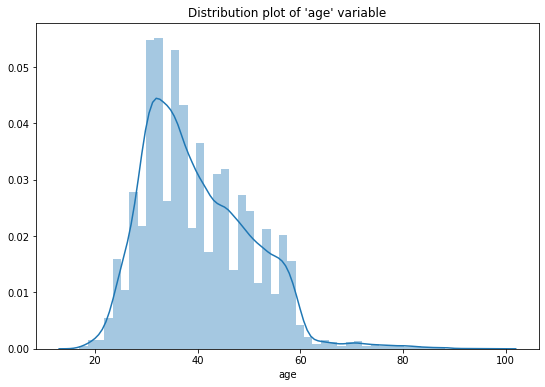

In [16]:
plot_dist_formated('age')

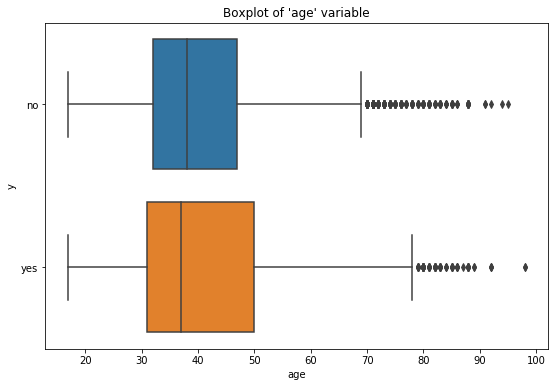

In [17]:
plot_boxplot_formated('age')

There are no outliers



#### 2. Job

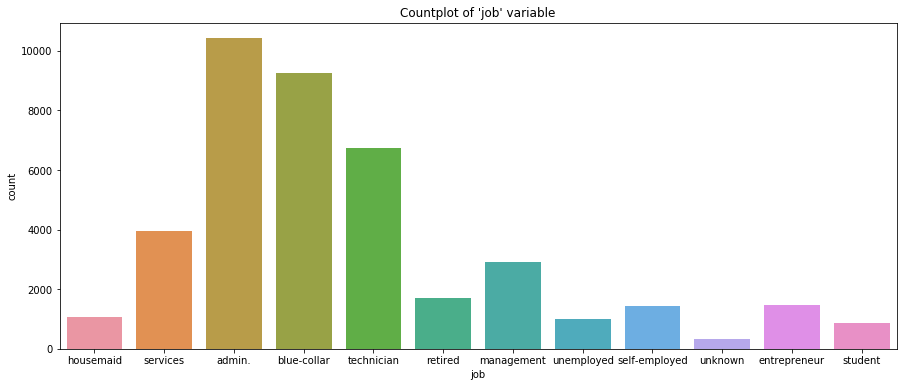

In [18]:
plot_countplot_formated('job')

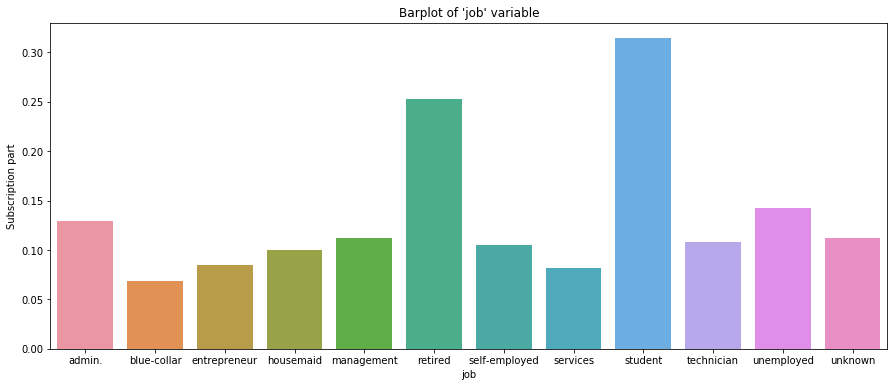

In [19]:
plot_barplot_formated('job')

It seems some columns have correlation with target variable.

#### 3. Marital

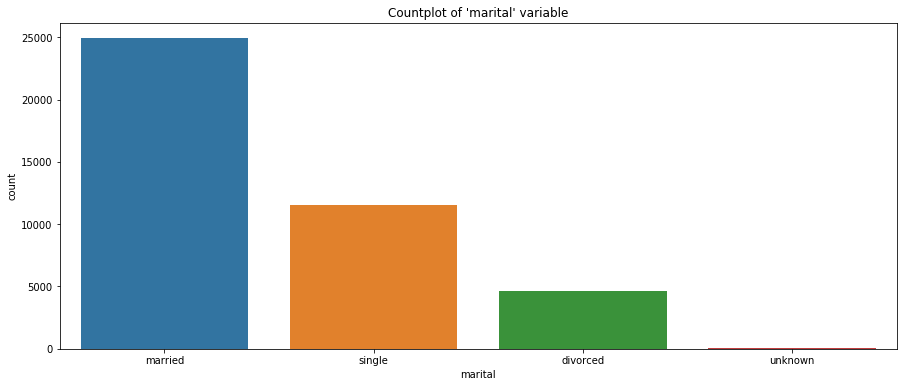

In [20]:
plot_countplot_formated('marital')

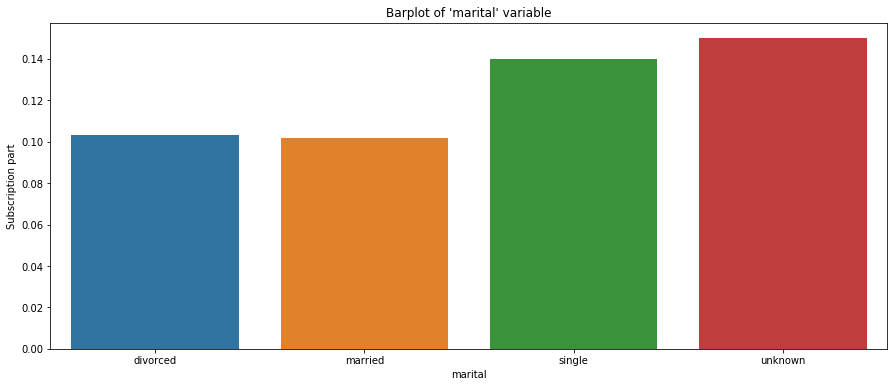

In [21]:
plot_barplot_formated('marital')

Some marital statuses may also have correlation with target.

#### 4. Education

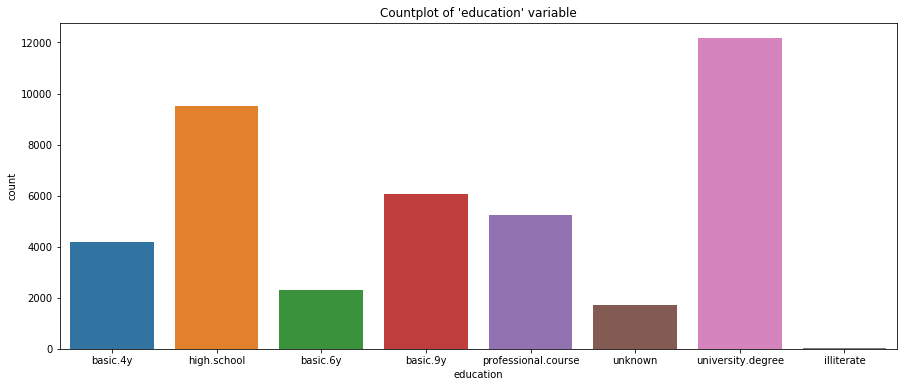

In [22]:
plot_countplot_formated('education')

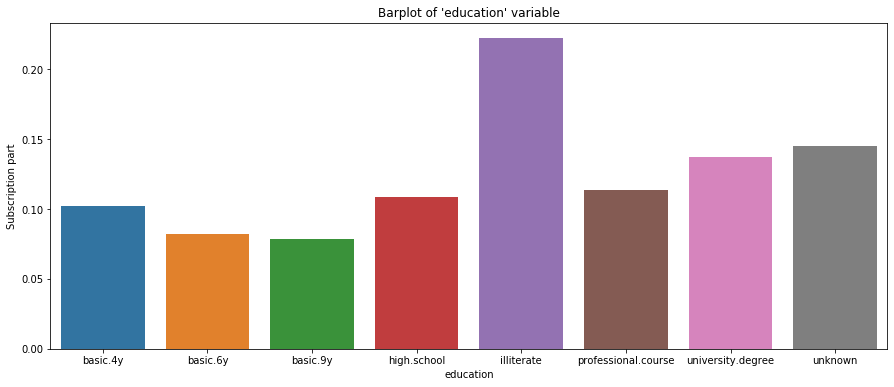

In [23]:
plot_barplot_formated('education')

#### 5. Default

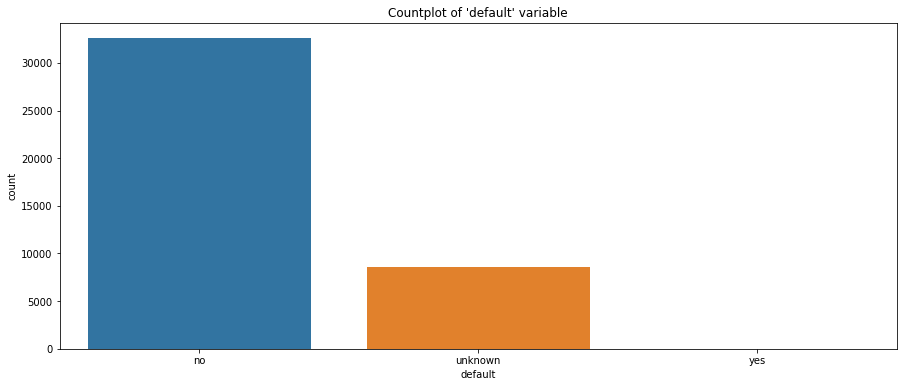

In [24]:
plot_countplot_formated('default')

In [25]:
data_1.default.value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

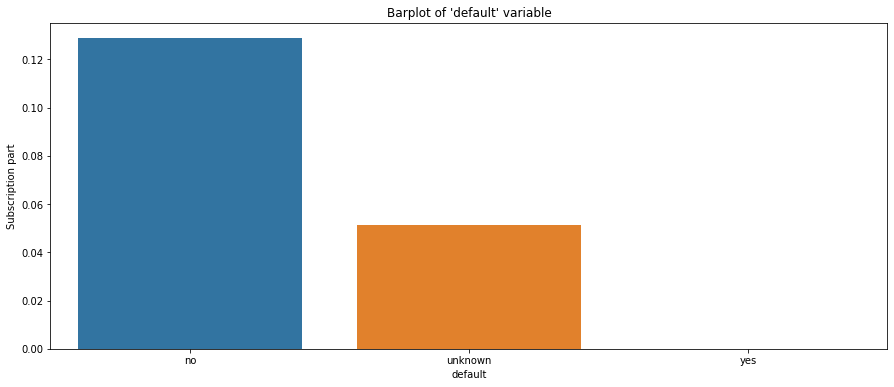

In [26]:
plot_barplot_formated('default')

The amount of people with default is very small. But there is a big difference in deposit acceptance rate between 'no' and 'unknown'. The possible reason is people with default might get in unknown group.

#### 6. Housing

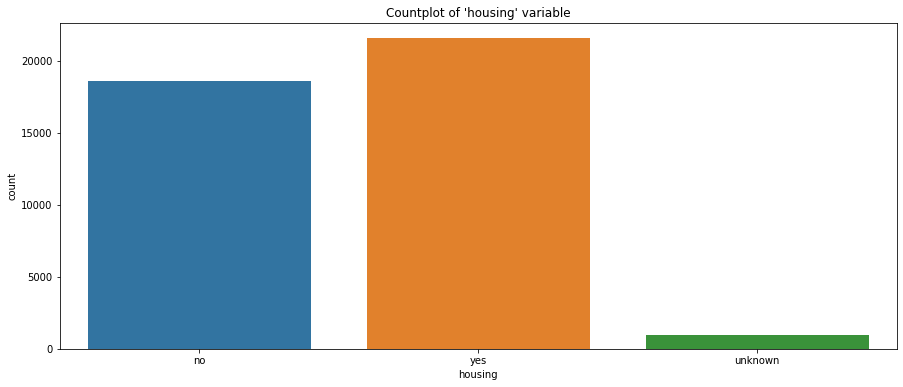

In [27]:
plot_countplot_formated('housing')

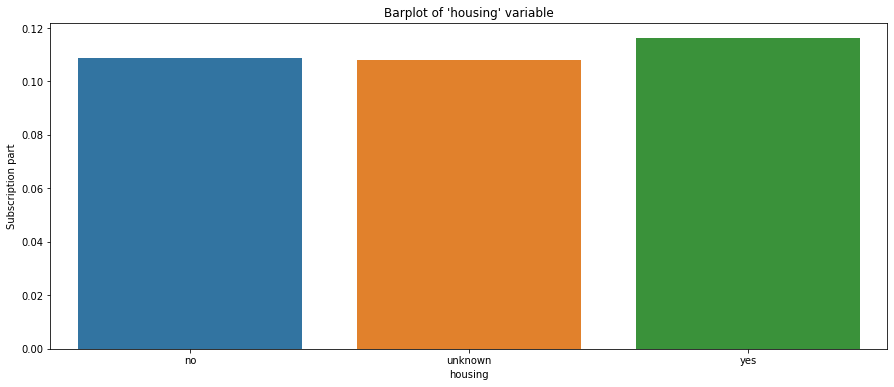

In [28]:
plot_barplot_formated('housing')

Nothing interesting

#### 7. Loan

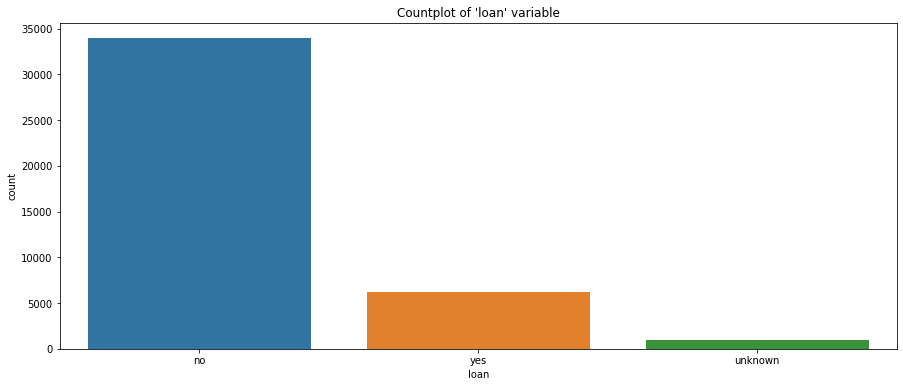

In [29]:
plot_countplot_formated('loan')

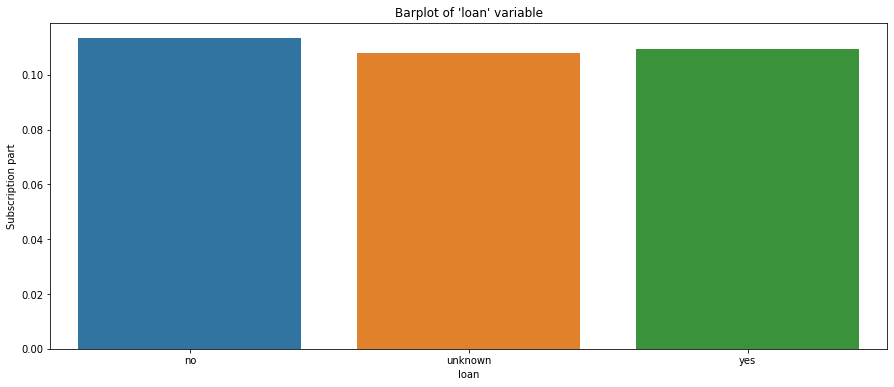

In [30]:
plot_barplot_formated('loan')

#### 8. Contact 

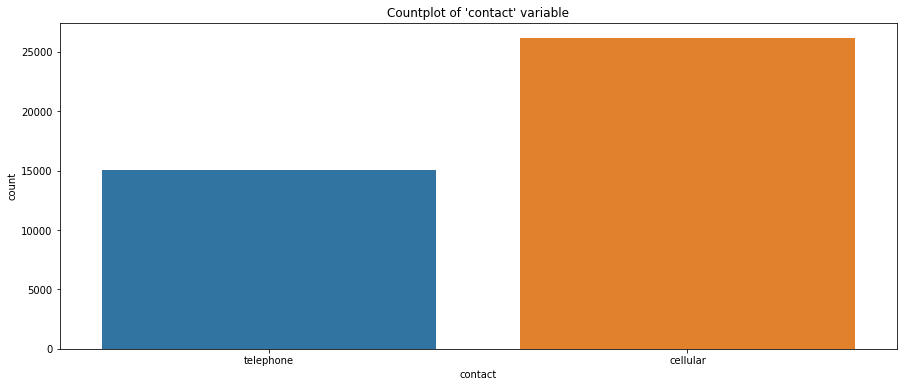

In [31]:
plot_countplot_formated('contact')

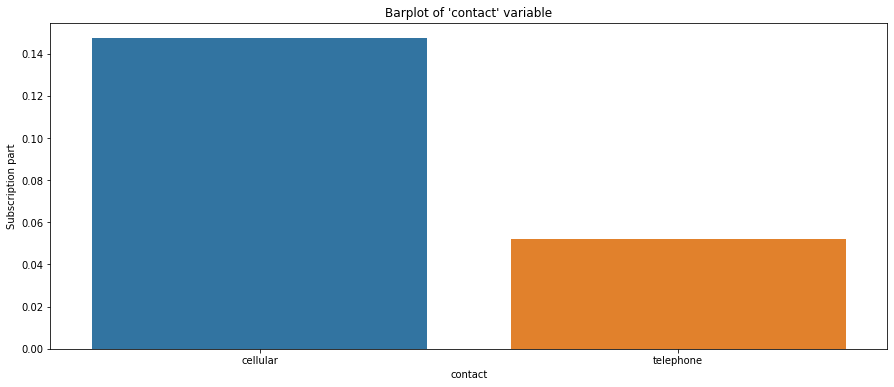

In [32]:
plot_barplot_formated('contact')

Looks like a useful feature. The correlction may be connected with wealth of subscribers

#### 9. Month

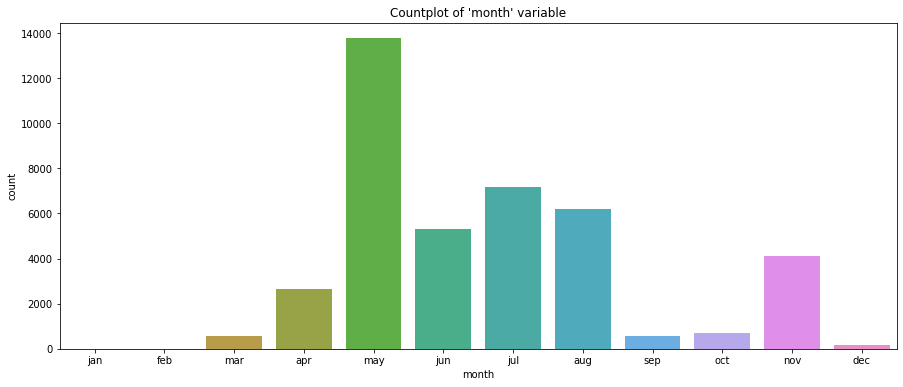

In [33]:
plot_countplot_formated('month', order=month_order)

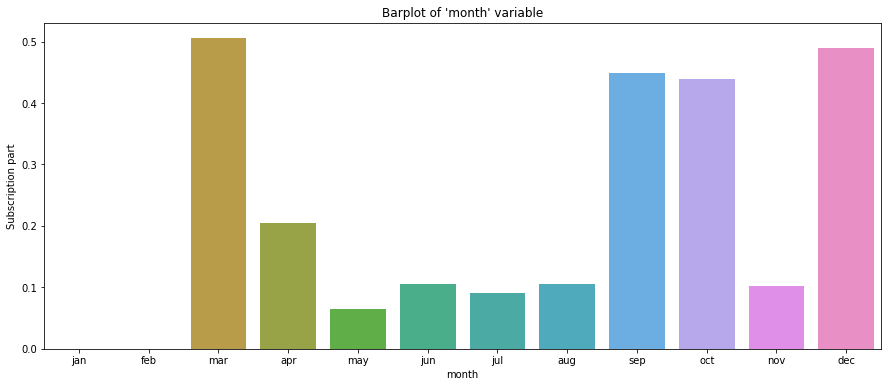

In [34]:
plot_barplot_formated('month', order=month_order)

The distribution of months is very strange. Let's take a look on mothes concatenated with years

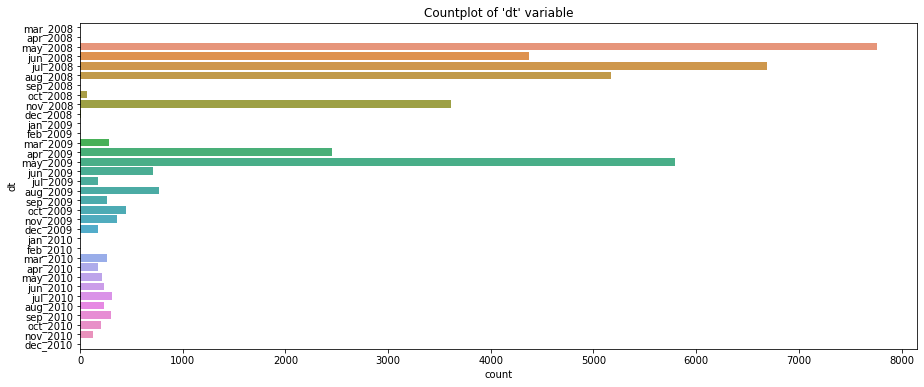

In [35]:
plot_countplot_formated('dt', orient='h', order=month_order_cv)

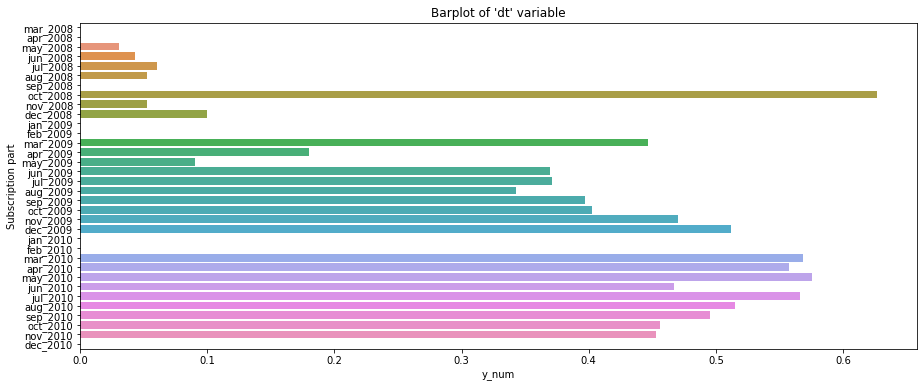

In [36]:
plot_barplot_formated('dt', order=month_order_cv, orient='h')

It's better not to use month as feature.

#### 10. Day of week

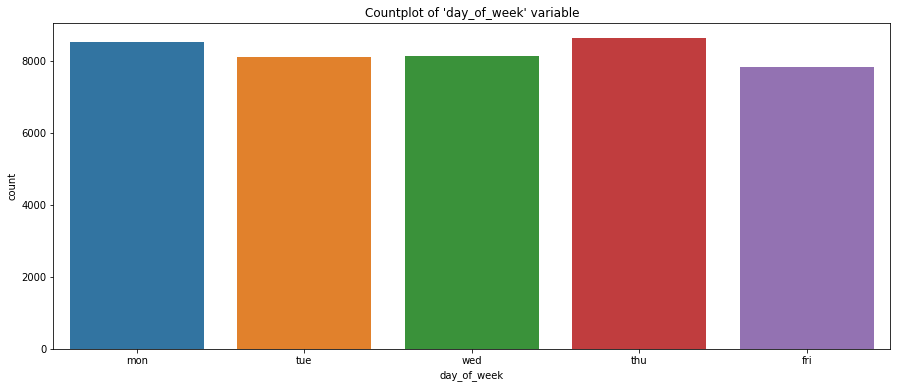

In [37]:
plot_countplot_formated('day_of_week')

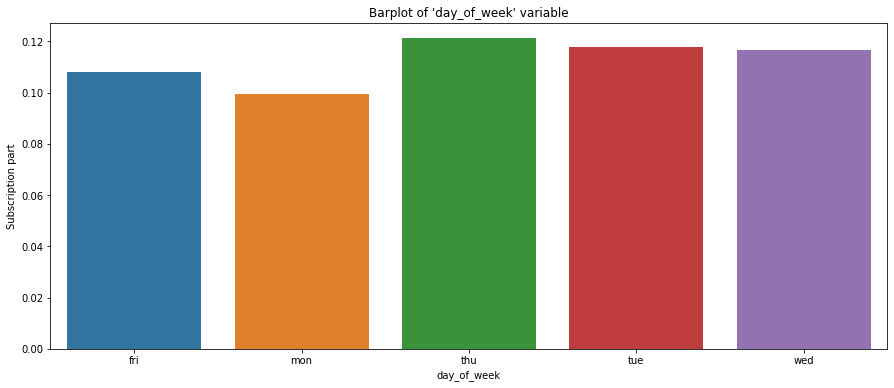

In [38]:
plot_barplot_formated('day_of_week')

All is OK

#### 11. Duration

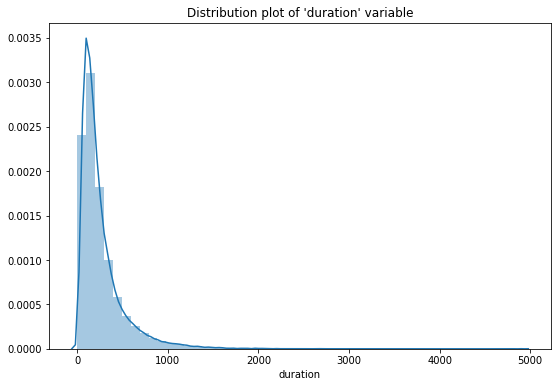

In [39]:
plot_dist_formated('duration')

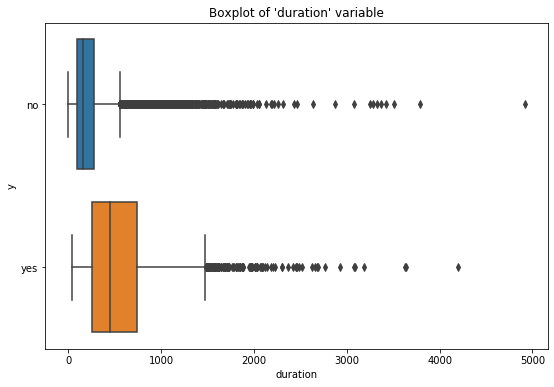

In [40]:
plot_boxplot_formated('duration')

We are not able to use this feature for prediction, because we don't know about a call duration before a call.

#### 12. Campaign 

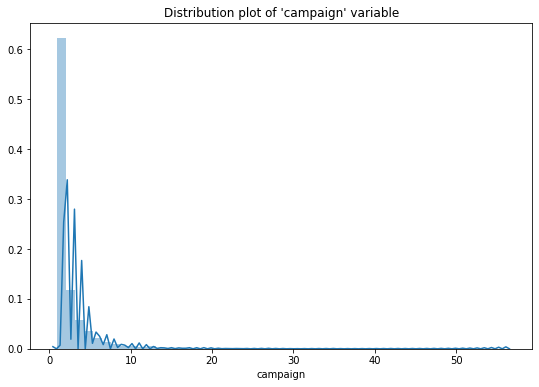

In [41]:
plot_dist_formated('campaign')

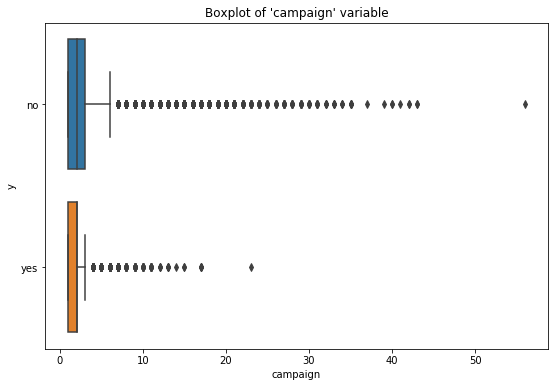

In [42]:
plot_boxplot_formated('campaign')

All is ok

#### 13. Pdays

In [43]:
data_1.pdays.value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

pdays=999 means that it will be the first contact with subscriber. We can create new feature 'is_first_contract' to help model to separate such clients

In [44]:
data_1['is_first_contact'] = data_1.pdays.apply(lambda x: 1 if x==999 else 0)

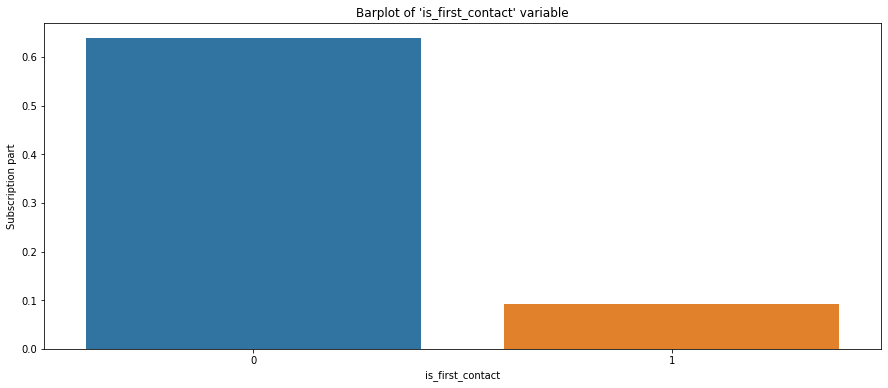

In [45]:
plot_barplot_formated('is_first_contact')

#### 14. Previous

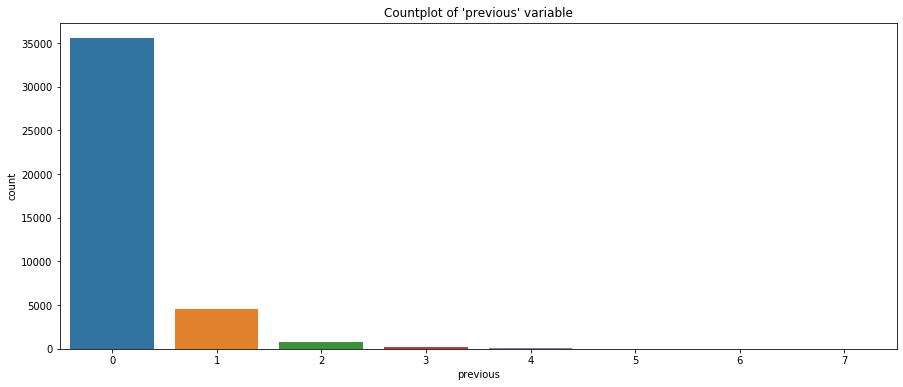

In [46]:
plot_countplot_formated('previous')

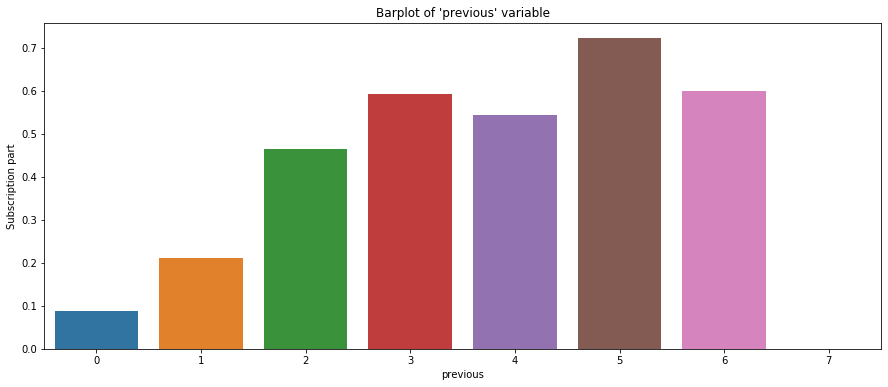

In [47]:
plot_barplot_formated('previous')

It looks like clients don't like to accept offers from the first call.

#### 15. Poutcome

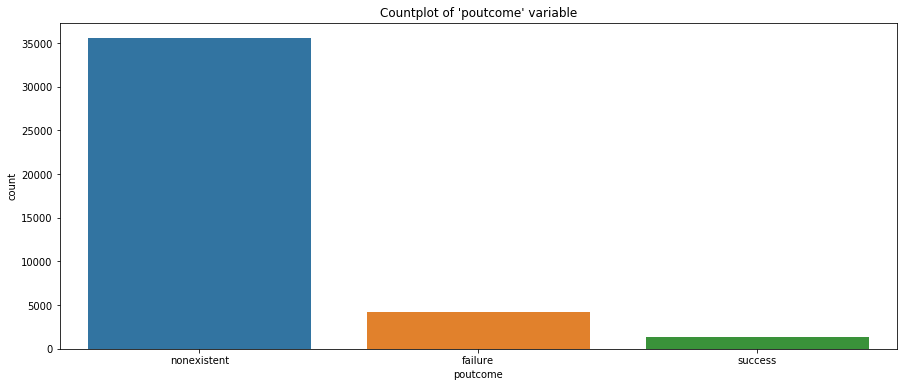

In [48]:
plot_countplot_formated('poutcome')

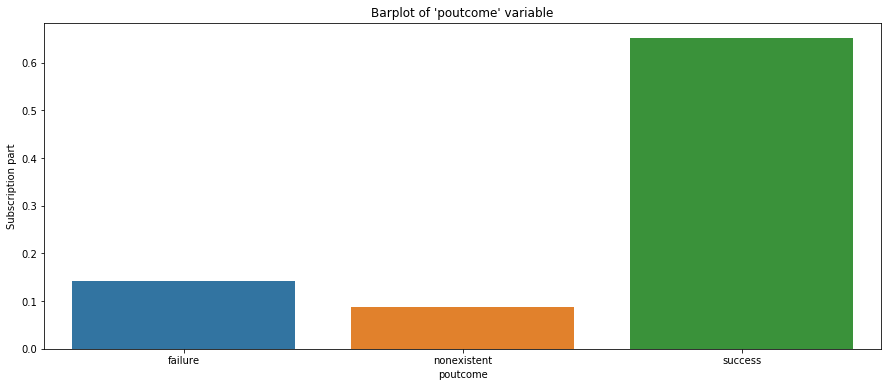

In [49]:
plot_barplot_formated('poutcome')

It's good when the client accepted an offer in the past

#### 16. emp. var. rate

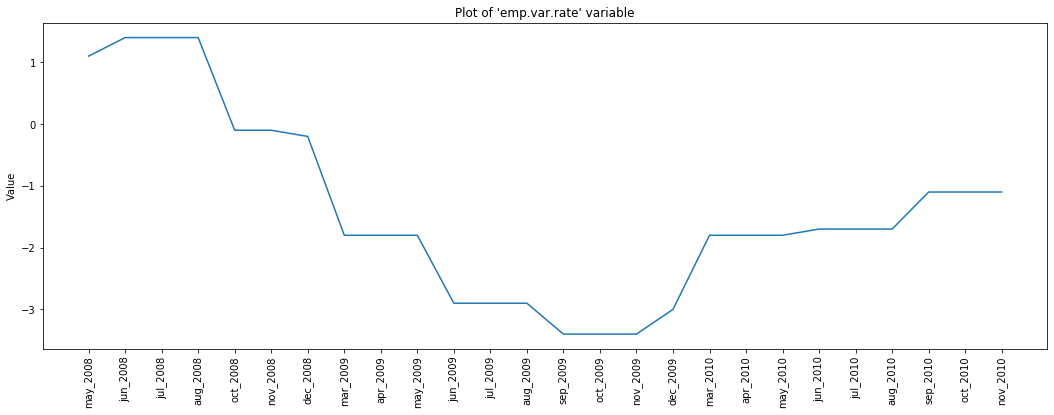

In [50]:
plot_time_var('emp.var.rate')

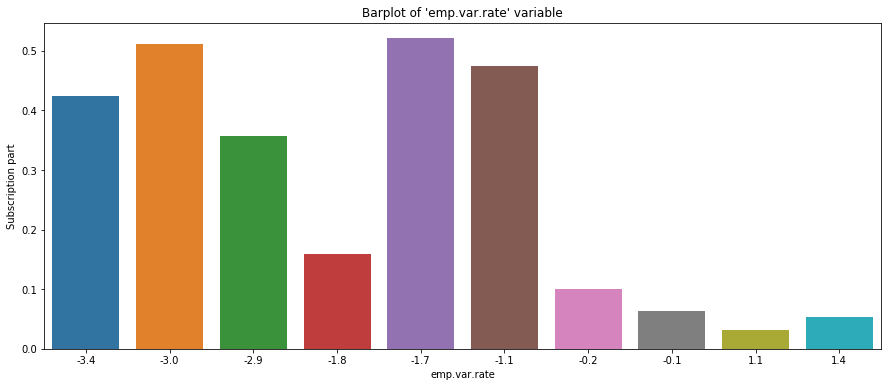

In [51]:
plot_barplot_formated('emp.var.rate')

In [52]:
tmp_dict = create_time_diff('emp.var.rate')
data_1['emp.var.rate_diff'] = data_1.dt.apply(lambda x: tmp_dict[x])

#### 17. Cons.price.idx

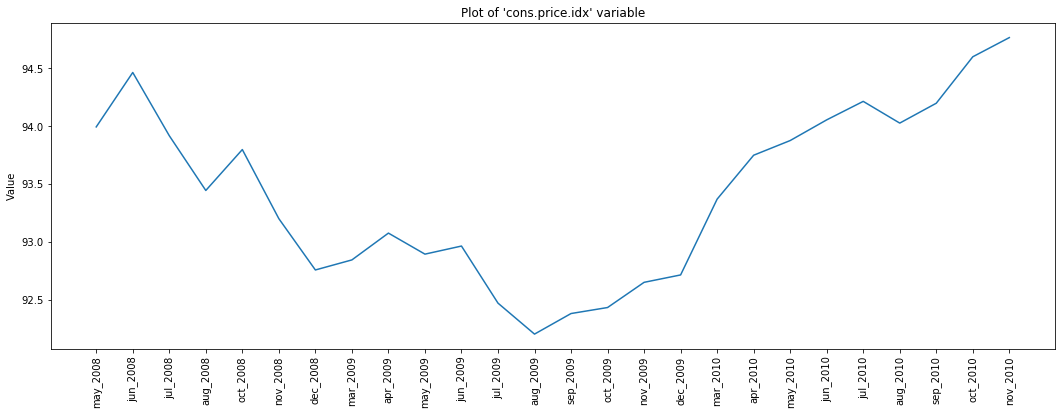

In [53]:
plot_time_var('cons.price.idx')

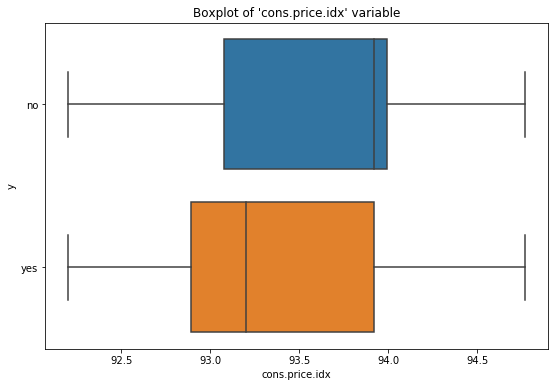

In [54]:
plot_boxplot_formated('cons.price.idx')

In [55]:
tmp_dict = create_time_diff('cons.price.idx')
data_1['cons.price.idx_diff'] = data_1.dt.apply(lambda x: tmp_dict[x])

Look's like an important feature

#### 18. Cons.conf.idx

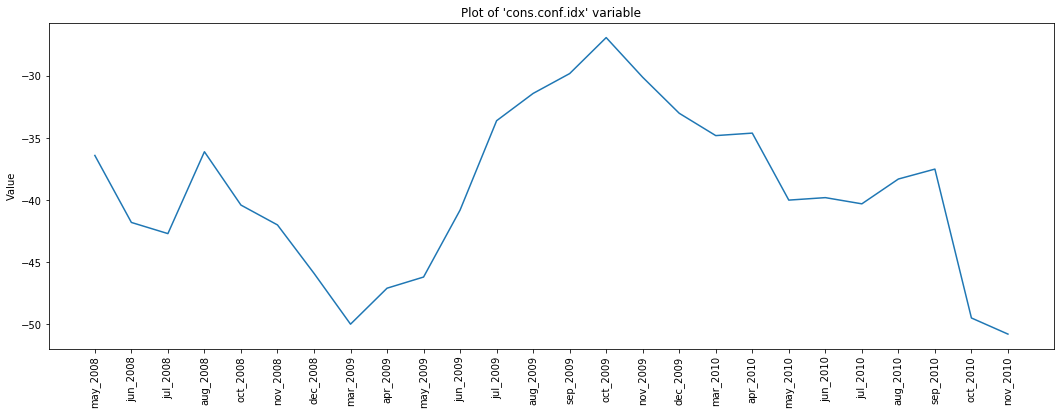

In [56]:
plot_time_var('cons.conf.idx')

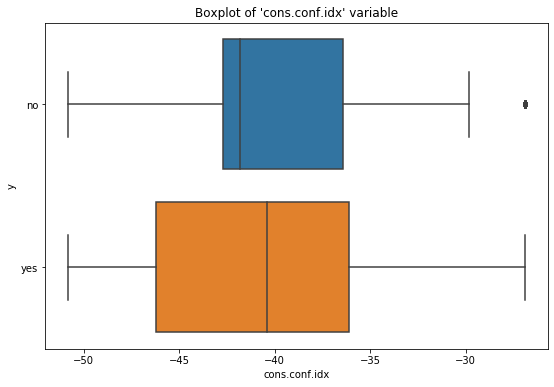

In [57]:
plot_boxplot_formated('cons.conf.idx')

In [58]:
tmp_dict = create_time_diff('cons.conf.idx')
data_1['cons.conf.idx_diff'] = data_1.dt.apply(lambda x: tmp_dict[x])

#### 19. Euribor3m

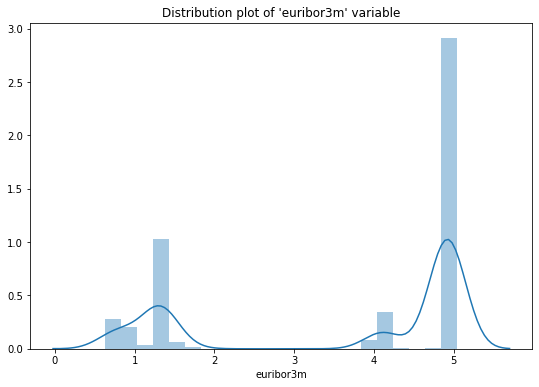

In [59]:
plot_dist_formated('euribor3m')

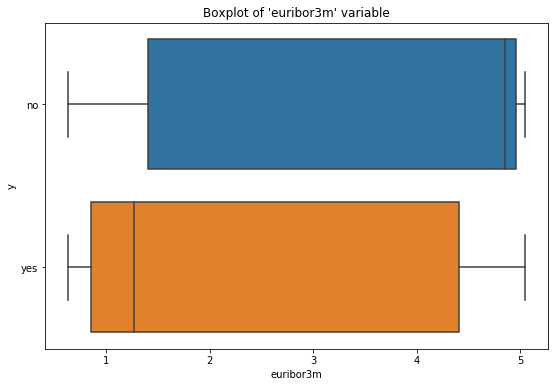

In [60]:
plot_boxplot_formated('euribor3m')

#### 20. nr.employed

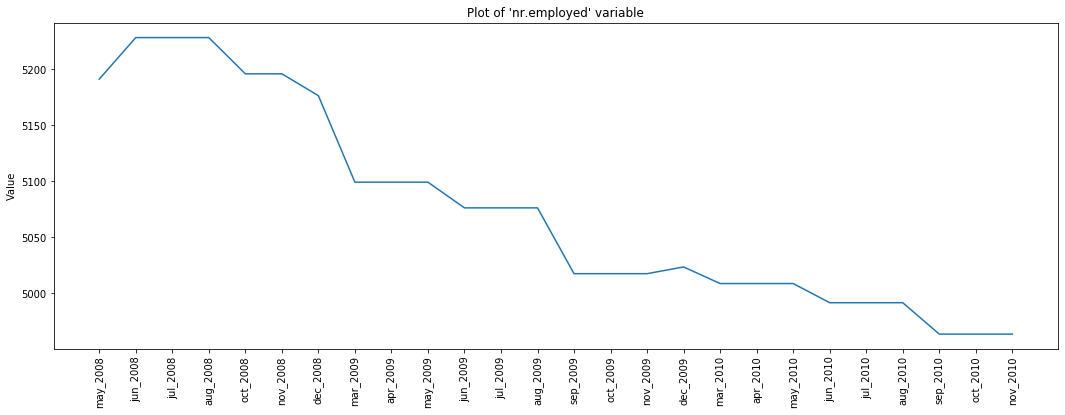

In [61]:
plot_time_var('nr.employed')

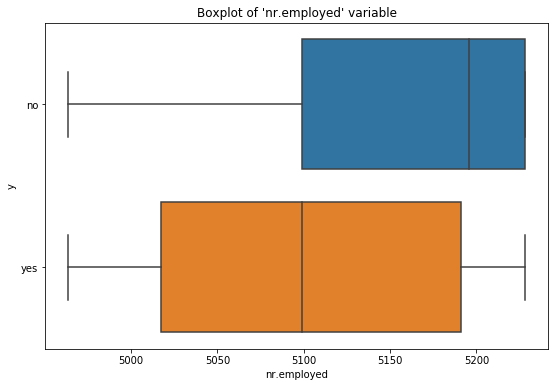

In [62]:
plot_boxplot_formated('nr.employed')

In [63]:
tmp_dict = create_time_diff('nr.employed')
data_1['nr.employed_diff'] = data_1.dt.apply(lambda x: tmp_dict[x])

## Modelling

I'm absolutely sure that best accuracy will be achieved by using boosting.

In [68]:
CAT_FEATURES = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact','day_of_week', 'poutcome']
x = data_1.drop(['y', 'y_num','month','year','dt_tmp'], axis=1)
y = data_1[['y_num']]

In [69]:
def one_hot_transform(x, features):
    for feature in features:
        oh = OneHotEncoder()
        feature_encoded = oh.fit_transform(x[[feature]]).toarray()
        for i, cat in enumerate(oh.categories_[0]):
            x[feature+'_'+cat]=feature_encoded[:,i]
        x.drop(feature, axis=1, inplace=True)
    return x

In [70]:
x_with_oh = one_hot_transform(x.copy(), CAT_FEATURES)

We are not able to perform usual k-fold cross-validation when we work with times-data, so we need to perform time-series cross-validation (train data must be earlier than validation/test data). We will use every month as a fold.

In [71]:
months = data_1.dt.unique()
def timeseries_cross_val(model, x, y):
    train_months = []
    scores = []
    for i in range(len(months)-1):
        train_months.append(months[i])
        train_ind = x.dt.isin(train_months)
        test_ind = x.dt==months[i+1]
        model.fit(x[train_ind].drop('dt',axis=1),y[train_ind])
        scores.append(roc_auc_score(y[test_ind],
                                    model.predict_proba(x[test_ind].drop('dt',axis=1))[:,1]))
    return scores

As metrics for comparison we will use:<br>1) mean value of roc-auc score<br>2) median value of roc-auc score<br>3) std of roc-auc score<br>4) mean value of roc-auc on last folds

In [72]:
def print_metrics(scores):
    print("Mean (roc-auc): %.4f" % np.mean(scores))
    print("Median (roc-auc): %.4f" % np.median(scores))
    print("Std (roc-auc): %.4f" % np.std(scores))
    print("Mean (roc-auc) last year: %.4f" % np.mean(scores[-9:]))

#### Logistic regression with target encoder

In [73]:
lr_target_pipeline = Pipeline([('cat_enc', TargetEncoder()),
                           ('scaler', StandardScaler()),
                          ('model', LogisticRegression(max_iter=1000))])

In [74]:
scores = timeseries_cross_val(lr_target_pipeline, x, y.y_num)

In [75]:
print_metrics(scores)

Mean (roc-auc): 0.6129
Median (roc-auc): 0.6057
Std (roc-auc): 0.1529
Mean (roc-auc) last year: 0.7264


#### Logistic regression with one hot encoder

In [73]:
lr_oh_pipeline = Pipeline([('scaler', StandardScaler()),
                          ('model', LogisticRegression(max_iter=1000))])

In [74]:
scores = timeseries_cross_val(lr_oh_pipeline, x_with_oh, y.y_num)
print_metrics(scores)

Mean (roc-auc): 0.6125
Median (roc-auc): 0.6074
Std (roc-auc): 0.1549
Mean (roc-auc) last year: 0.7324


#### Random forest with target encoder

In [75]:
rf_target_pipeline = Pipeline([('cat_enc', TargetEncoder()),
                          ('model', RandomForestClassifier(n_estimators=100))])

In [76]:
scores = timeseries_cross_val(rf_target_pipeline, x, y.y_num)
print_metrics(scores)

Mean (roc-auc): 0.5924
Median (roc-auc): 0.5776
Std (roc-auc): 0.1060
Mean (roc-auc) last year: 0.7006


#### Random forest with one hot encoder

In [77]:
rf_oh_pipeline = Pipeline([('model', RandomForestClassifier(n_estimators=100))])

In [78]:
scores = timeseries_cross_val(rf_oh_pipeline, x_with_oh, y.y_num)
print_metrics(scores)

Mean (roc-auc): 0.5994
Median (roc-auc): 0.5706
Std (roc-auc): 0.1074
Mean (roc-auc) last year: 0.7120


#### Multinomial NB with one hot encoder

In [79]:
nb_oh_pipeline = Pipeline([('scaler', MinMaxScaler()),
                          ('model', MultinomialNB())])

In [80]:
scores = timeseries_cross_val(nb_oh_pipeline, x_with_oh, y.y_num)

In [81]:
print_metrics(scores)

Mean (roc-auc): 0.5774
Median (roc-auc): 0.5814
Std (roc-auc): 0.1283
Mean (roc-auc) last year: 0.6594


#### Multinomial NB with target encoder

In [82]:
nb_target_pipeline = Pipeline([('cat_enc', TargetEncoder()),
                               ('scaler', MinMaxScaler()),
                          ('model', MultinomialNB())])

In [83]:
scores = timeseries_cross_val(nb_target_pipeline, x, y.y_num)

In [84]:
print_metrics(scores)

Mean (roc-auc): 0.5726
Median (roc-auc): 0.5805
Std (roc-auc): 0.1134
Mean (roc-auc) last year: 0.6500


#### Catboost encoder

In [85]:
model = CatBoostClassifier(cat_features=CAT_FEATURES, verbose=False)

In [86]:
%%time
scores = timeseries_cross_val(model, x, y.y_num)

CPU times: user 1h 1min 50s, sys: 8min 33s, total: 1h 10min 24s
Wall time: 11min 32s


In [87]:
print_metrics(scores)

Mean (roc-auc): 0.5893
Median (roc-auc): 0.5741
Std (roc-auc): 0.1309
Mean (roc-auc) last year: 0.7004


Logistic regresion has the best score. In real problem we can try to finetune all models, but I will skip it because it requires a lot of time.

In [76]:
lr_oh_pipeline = Pipeline([('scaler', StandardScaler()),
                  ('model', LogisticRegression(max_iter=1000))])
lr_oh_pipeline.fit(x_with_oh.drop('dt', axis=1), y.y_num)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [77]:
print_metrics(timeseries_cross_val(lr_oh_pipeline, x_with_oh, y.y_num))

Mean (roc-auc): 0.6125
Median (roc-auc): 0.6074
Std (roc-auc): 0.1549
Mean (roc-auc) last year: 0.7324


The best roc-auc score on the last year data is <b>0.7324</b>

Let's take a look at feature importance

In [78]:
feature_imp = []
for feature, score in zip(x_with_oh.drop('dt', axis=1).columns, lr_oh_pipeline['model'].coef_[0]):
    feature_imp.append([feature, score])

In [79]:
feature_imp_df = pd.DataFrame(feature_imp, columns=['feature', 'importance'])
feature_imp_df['tmp_sort'] = np.abs(feature_imp_df.importance)
feature_imp_df.sort_values(by='tmp_sort', ascending=False, inplace=True)

In [80]:
feature_imp_df[['feature','importance']].head(10)

,feature,importance
4,emp.var.rate,-1.289947
5,cons.price.idx,0.649275
7,euribor3m,0.501431
8,nr.employed,-0.342526
2,pdays,-0.223952
47,contact_cellular,0.221386
48,contact_telephone,-0.221386
12,cons.conf.idx_diff,0.120666
6,cons.conf.idx,0.116920
1,campaign,-0.111703


### Lift curve 

To plot a lift curve I will use the last 6 monthss as test data.

In [143]:
train_ind = x_with_oh.dt.isin(month_order_cv[:-6])
test_ind = x_with_oh.dt.isin(month_order_cv[-6:])

In [144]:
lr_oh_pipeline = Pipeline([('scaler', StandardScaler()),
                  ('model', LogisticRegression(max_iter=1000))])
lr_oh_pipeline.fit(x_with_oh[train_ind].drop('dt', axis=1), y[train_ind].y_num)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [145]:
print(roc_auc_score(y[test_ind],
                    lr_oh_pipeline.predict_proba(x_with_oh[test_ind].drop('dt',axis=1))[:,1]))

0.7494531650232836


In [146]:
calls_scores = lr_oh_pipeline.predict_proba(x_with_oh[test_ind].drop('dt',axis=1))[:,1]
pos_rate = y[test_ind].y_num.mean()
percents = np.arange(0.01, 1, 0.01)
curve_dots = []
for target_percent in percents:
    threshold = np.quantile(calls_scores, q=1-target_percent)
    predicted_classes = [1 if x >= threshold else 0 for x in calls_scores]
    curve_dots.append((precision_score(y[test_ind], predicted_classes)/pos_rate - 1)*100)

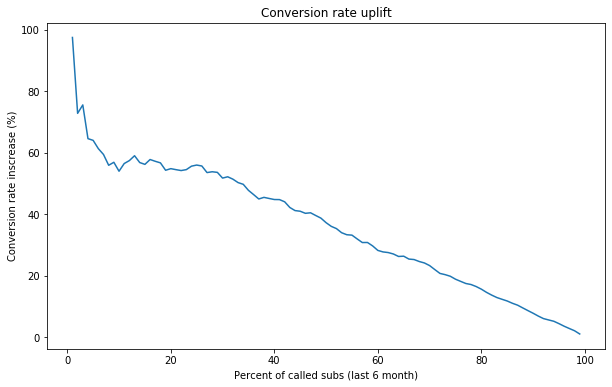

In [161]:
plt.figure(figsize=(10,6))
plt.plot(percents*100, curve_dots)
plt.xlabel('Percent of called subs (last 6 month)')
plt.ylabel('Conversion rate inscrease (%)')
plt.title('Conversion rate uplift')
plt.show()

<h3>Results</h3>

I've created a model that can score clients according their probability of accepting a deposit offer. The roc-auc score on the last year data is <b>0.7324</b> (or Gini coef. is <b>0,4648</b>), but this is only an offline metric. I will propose the customer to test this model using A/B tests. We can use the following experiment:

Let we have 2X clients and we are able to call 2k clients.<br>
1) We divide these 2X clients into 2 equal groups <b>randomly</b>.<br>
2) The customer selects k clients from the first group for calling using his own methology.<br>
3) I select k clients from the second group for calling using the model.<br>
4) We define a criteria of success (f.e. response of my clients is better than responce of customer clients on P%)<br>
5) We will check criteria of success after all calls be finished.<br>
6) We can also repeat the experiment several times.<br>
If the customer is satisfied with results we will start talking about integration of the model.<br>
We can skip 1), but in that case we can have same clients.<br>
X, k depends on customer capabilites. P depends on customer expectations.

P.S. I'm also thinking about proposing the customer to build an uplift model (https://habr.com/ru/company/ru_mts/blog/485980/). The main disadvantages are impossobility to guarantee the suscess of that idea and necessity to get data about clients not participated in marketing campaigns (it can be difficult to get).